<a href="https://colab.research.google.com/github/kate-simonova/cancer-subtyping/blob/main/02_QC_DeepCC_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # DL based models for cancer subtype identification - Data quality check with DeepCC

This notebook is used to prove that preprocessing of the data was done perfectly. As one of the most important steps in preprocessing was conversion to functional spectra. I decided to use DeepCC MLP algorithm on my data, to make sure that everything is done well.

**Keywords:** Subtyping, Cancer, Gene Expression, Tumor Microenvironment

## Data Loading and installation of packages

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing necessary packages

from google.colab import drive
drive.mount('/content/drive', force_remount=True) 
path = "/content/drive/MyDrive/MY_DATA/FS/"

import re
import gc
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras

import plotly.express as px
from keras.utils import plot_model
from keras.layers import Dropout, BatchNormalization, Dense, Input
from keras.utils.vis_utils import plot_model
from keras.models import Model
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.cluster import KMeans

from keras import backend
from keras import initializers
from sklearn.model_selection import KFold
from keras import backend as K
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder

Mounted at /content/drive


## Loading colorectal data 

In [ ]:
# loading colorectal cancer dataset
crc_df = pd.read_csv(f"{path}/crc_fs_final.csv.zip", compression="zip", index_col=0)
crc_meta = pd.read_csv(f"{path}/crc_metadata.csv.zip", compression="zip", index_col=0)
crc_df = crc_df.loc[crc_meta["Sample"], :]
crc_meta["Cancer"] = "Colorectal"
crc_meta.shape

(2436, 6)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(crc_df, crc_meta["Label"], test_size=0.15, random_state=42, stratify=crc_meta["Label"])

In [ ]:
mapp = LabelEncoder()

y_train_adasyn = mapp.fit_transform(y_train).ravel()

before_counter = Counter(y_train)
print('Before', before_counter)

ada = ADASYN(random_state=0, sampling_strategy='all')
x_train_ada, y_train_ada = ada.fit_resample(X_train, y_train_adasyn)

after_counter = Counter(y_train_ada)
print('After', after_counter)

Before Counter({'CMS2': 901, 'CMS4': 537, 'CMS1': 357, 'CMS3': 275})
After Counter({3: 943, 0: 904, 1: 901, 2: 897})


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_train_ada, y_train_ada, test_size=0.20, random_state=42, stratify=y_train_ada)

## Loading breast cancer data

In [ ]:
# loading breast cancer dataset
brca_df = pd.read_csv(f"{path}/brca_fs_final.csv.zip", compression="zip", index_col=0)
brca_meta = pd.read_csv(f"{path}/metadata_breast_combined.csv.zip", compression="zip", index_col=0)
brca_df = brca_df.loc[brca_meta["Sample ID"], :]
brca_meta["Cancer"] = "Breast"
brca_meta.shape

(11264, 6)

## DeepCC 

In [ ]:
keras.backend.clear_session()

In [ ]:
gc.collect()

0

In [ ]:
#del model

In [ ]:
original_dim = 22596
dim1 = 1024
dim2 = 256
dim3 = 64
dim4 = 64
dim5 = 10
dropout_rate = 0.4
epochs = 100
batch_size=1024

model = keras.Sequential()
model.add(Input(shape=(original_dim,)))
model.add(BatchNormalization())
initializer = keras.initializers.GlorotNormal()
model.add(Dense(dim1, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim2, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim3, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim4, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim5, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim5, activation='softmax'))

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 22596)            90384     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              23139328  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                        

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics="accuracy")

## Running DeepCC on colorectal cancer dataset

In [ ]:
print(X_train.shape, y_train.shape)

(2916, 22596) (2916,)


In [ ]:
print(X_val.shape, y_val.shape)

(729, 22596) (729,)


In [ ]:
history = model.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size, 
                validation_data=(X_val, y_val))

Epoch 1/100
3/3 [==============================] - 8s 389ms/step - loss: 2.3137 - accuracy: 0.2305 - val_loss: 1.6650 - val_accuracy: 0.5267
Epoch 2/100
3/3 [==============================] - 0s 188ms/step - loss: 2.0483 - accuracy: 0.3186 - val_loss: 1.4840 - val_accuracy: 0.6735
Epoch 3/100
3/3 [==============================] - 0s 173ms/step - loss: 1.8950 - accuracy: 0.3800 - val_loss: 1.3913 - val_accuracy: 0.6845
Epoch 4/100
3/3 [==============================] - 0s 177ms/step - loss: 1.7437 - accuracy: 0.4578 - val_loss: 1.2825 - val_accuracy: 0.7037
Epoch 5/100
3/3 [==============================] - 0s 164ms/step - loss: 1.6369 - accuracy: 0.5014 - val_loss: 1.2327 - val_accuracy: 0.7174
Epoch 6/100
3/3 [==============================] - 0s 144ms/step - loss: 1.5348 - accuracy: 0.5340 - val_loss: 1.2075 - val_accuracy: 0.6914
Epoch 7/100
3/3 [==============================] - 0s 165ms/step - loss: 1.4883 - accuracy: 0.5614 - val_loss: 1.1413 - val_accuracy: 0.7160
Epoch 8/100
3

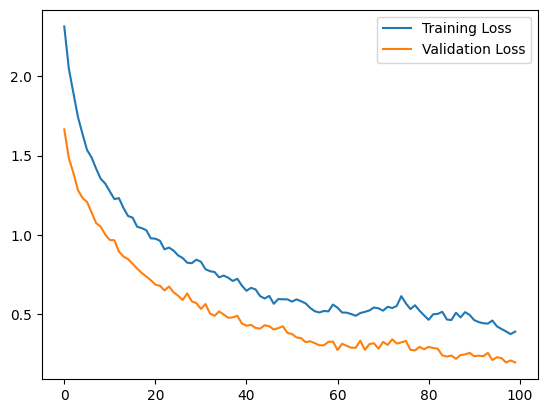

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
p = model.predict(X_test, batch_size=batch_size)
final_layer = pd.DataFrame(p)
final_layer

1/1 [==============================] - 0s 164ms/step


,0,1,2,3,4,5,6,7,8,9
0,0.000250,0.024055,0.013774,0.910349,0.006513,0.007167,0.008050,0.007457,0.014059,0.008325
1,0.000303,0.020780,0.020142,0.905303,0.006602,0.006943,0.008797,0.007873,0.015199,0.008059
2,0.001576,0.953531,0.005002,0.012979,0.003519,0.005344,0.004556,0.005806,0.004055,0.003632
3,0.000248,0.023645,0.013986,0.910595,0.006489,0.007135,0.008070,0.007441,0.014063,0.008328
4,0.000269,0.025874,0.012623,0.909283,0.006704,0.007317,0.008002,0.007671,0.014040,0.008218
...,...,...,...,...,...,...,...,...,...,...
361,0.013925,0.011346,0.946545,0.003948,0.002978,0.002918,0.003169,0.003264,0.009702,0.002206
362,0.461689,0.000653,0.110675,0.040949,0.080571,0.052554,0.061923,0.048929,0.066943,0.075114
363,0.001607,0.953819,0.005019,0.012729,0.003514,0.005323,0.004547,0.005803,0.004039,0.003600
364,0.013832,0.011295,0.946774,0.003959,0.002963,0.002906,0.003152,0.003248,0.009680,0.002191


### UMAP

In [ ]:
umap_2d = UMAP(n_components=2, n_neighbors=55, init='random', metric= "chebyshev", random_state=0, min_dist=1)
proj_2d = umap_2d.fit_transform(final_layer)

In [ ]:
plot_df = pd.DataFrame(proj_2d, columns = ["D1", "D2"])
plot_df["color"] = y_test.tolist()
plot_df.head()

,D1,D2,color
0,2.539529,12.075924,CMS4
1,3.525948,10.549582,CMS4
2,2.063217,-2.599476,CMS2
3,7.047028,5.954832,CMS4
4,5.138756,9.330332,CMS4


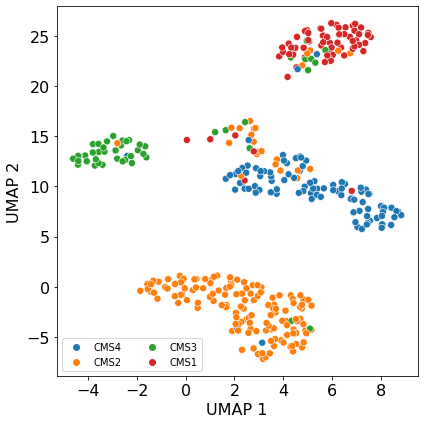

In [ ]:
plt.figure(figsize=(6,6))

sns.scatterplot(x="D1", y="D2", s=50, hue="color", data=plot_df, legend=True)
plt.xlabel("UMAP 1", fontsize=16)
plt.ylabel("UMAP 2", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.savefig(f"{path}/colorectal_tSNE_DseepCC.pdf", format="pdf")
plt.legend(prop={'size': 10}, loc="lower left", ncol=2)
plt.tight_layout()
plt.show()

### Clustering metrics calculation

In [ ]:
silhouetteScore = silhouette_score(final_layer, y_test, metric="euclidean")
davies_bouldinScore = davies_bouldin_score(final_layer, y_test)

km = KMeans(n_clusters=4, random_state=42)
y_pred = km.fit_predict(final_layer)
ari = adjusted_rand_score(y_pred, y_test)

print(f"Silhuette score: {round(silhouetteScore, 3)}", f"Rand Index {ari}", f"Davies-Bouldin score {round(davies_bouldinScore,3)}")

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhuette score: 0.6759999990463257 Rand Index 0.7135678974625833 Davies-Bouldin score 0.541


## Running DeepCC on breast dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(brca_df, brca_meta["PAM50"], test_size=0.15, random_state=42, stratify=brca_meta["PAM50"])

In [ ]:
mapp = LabelEncoder()

y_train_adasyn = mapp.fit_transform(y_train).ravel()

before_counter = Counter(y_train)
print('Before', before_counter)

ada = ADASYN(random_state=0, sampling_strategy='all')
x_train_ada, y_train_ada = ada.fit_resample(X_train, y_train_adasyn)

after_counter = Counter(y_train_ada)
print('After', after_counter)

Before Counter({'Luminal A': 4139, 'Luminal B': 2212, 'Basal-like': 1506, 'Her2': 985, 'Normal-like': 563, 'Claudin-low': 169})
After Counter({0: 4170, 2: 4147, 3: 4139, 1: 4138, 5: 4101, 4: 3829})


In [ ]:
keras.backend.clear_session()
del model

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_train_ada, y_train_ada, test_size=0.20, random_state=42, stratify=y_train_ada)

In [ ]:
original_dim = 22596
dim1 = 1024
dim2 = 256
dim3 = 64
dim4 = 64
dim5 = 10
dropout_rate = 0.4
epochs = 100
batch_size=1024

model = keras.Sequential()
model.add(Input(shape=(original_dim,)))
model.add(BatchNormalization())
initializer = keras.initializers.GlorotNormal()
model.add(Dense(dim1, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim2, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim3, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim4, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim5, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim5, activation='softmax'))

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics="accuracy")

In [ ]:
history = model.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size, 
                validation_data=(X_val, y_val))

Epoch 1/100
20/20 [==============================] - 10s 340ms/step - loss: 1.9657 - accuracy: 0.2893 - val_loss: 1.4083 - val_accuracy: 0.5710
Epoch 2/100
20/20 [==============================] - 2s 118ms/step - loss: 1.6144 - accuracy: 0.4414 - val_loss: 1.1725 - val_accuracy: 0.6712
Epoch 3/100
20/20 [==============================] - 2s 117ms/step - loss: 1.3983 - accuracy: 0.5435 - val_loss: 1.0293 - val_accuracy: 0.7272
Epoch 4/100
20/20 [==============================] - 2s 124ms/step - loss: 1.2586 - accuracy: 0.6137 - val_loss: 0.8794 - val_accuracy: 0.7798
Epoch 5/100
20/20 [==============================] - 2s 122ms/step - loss: 1.1489 - accuracy: 0.6553 - val_loss: 0.7878 - val_accuracy: 0.8110
Epoch 6/100
20/20 [==============================] - 2s 119ms/step - loss: 1.0823 - accuracy: 0.6828 - val_loss: 0.7353 - val_accuracy: 0.8253
Epoch 7/100
20/20 [==============================] - 2s 118ms/step - loss: 1.0043 - accuracy: 0.7084 - val_loss: 0.6626 - val_accuracy: 0.846

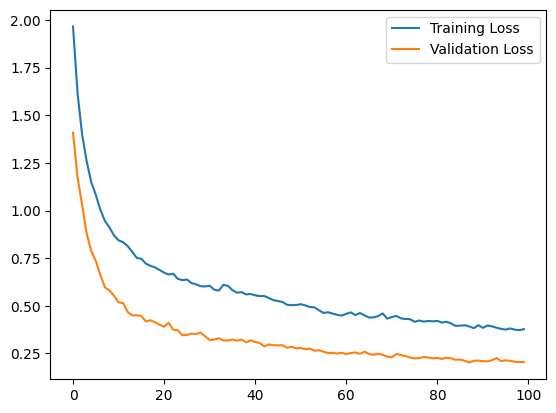

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
p = model.predict(X_test, batch_size=batch_size)
final_layer = pd.DataFrame(p)
final_layer

2/2 [==============================] - 0s 48ms/step


,0,1,2,3,4,5,6,7,8,9
0,0.000114,0.000484,0.020932,0.176502,0.797602,0.000708,0.000885,0.001030,0.000796,0.000947
1,0.000002,0.000292,0.000502,0.957445,0.031324,0.007928,0.000611,0.000682,0.000650,0.000563
2,0.987444,0.004842,0.005168,0.000006,0.000161,0.000408,0.000469,0.000460,0.000496,0.000546
3,0.004660,0.992925,0.000049,0.000128,0.000211,0.000755,0.000266,0.000282,0.000299,0.000424
4,0.000611,0.000459,0.090682,0.031748,0.873196,0.000176,0.000677,0.000822,0.000659,0.000969
...,...,...,...,...,...,...,...,...,...,...
1685,0.000141,0.000273,0.024919,0.353409,0.612873,0.002275,0.001557,0.001762,0.001406,0.001383
1686,0.000405,0.001065,0.000537,0.014913,0.000189,0.981365,0.000383,0.000388,0.000402,0.000352
1687,0.000506,0.000864,0.000628,0.012331,0.000170,0.983998,0.000377,0.000382,0.000399,0.000345
1688,0.987442,0.004843,0.005170,0.000006,0.000161,0.000408,0.000469,0.000460,0.000496,0.000546


### UMAP

In [ ]:
umap_2d = UMAP(n_components=2, n_neighbors=125, init='random', metric="chebyshev", random_state=0, min_dist=1)
proj_2d = umap_2d.fit_transform(final_layer)


In [ ]:
plot_df = pd.DataFrame(proj_2d, columns = ["D1", "D2"])
plot_df["color"] = y_test.tolist()
plot_df.head()

,D1,D2,color
0,4.425699,12.244297,Luminal B
1,0.356263,-7.249042,Luminal A
2,32.814812,6.563891,Basal-like
3,-28.406097,-3.696659,Claudin-low
4,0.886038,14.905550,Her2


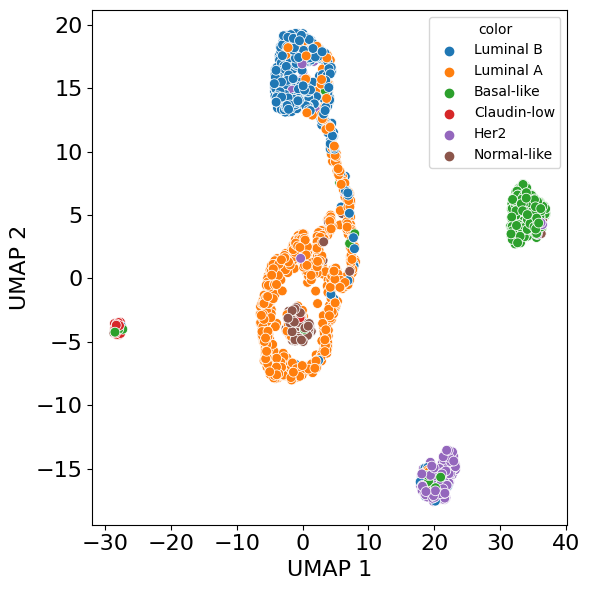

In [ ]:
plt.figure(figsize=(6,6))

sns.scatterplot(x="D1", y="D2", s=50, hue="color", data=plot_df, legend=True)
plt.xlabel("UMAP 1", fontsize=16)
plt.ylabel("UMAP 2", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(f"{path}/breast_UMAP_DseepCC.pdf", format="pdf")
#plt.legend(prop={'size': 10}, loc="lower left", ncol=2)
plt.tight_layout()
plt.show()

### Clustering metrics calculation

In [ ]:
silhouetteScore = silhouette_score(final_layer, y_test, metric="euclidean")
davies_bouldinScore = davies_bouldin_score(final_layer, y_test)

km = KMeans(n_clusters=6, random_state=42)
y_pred = km.fit_predict(final_layer)
ari = adjusted_rand_score(y_pred, y_test)

print(f"Silhuette score: {round(silhouetteScore,3)}", f"Rand Index {round(ari, 3)}" f"Davies-Bouldin score {round(davies_bouldinScore,3)}")

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhuette score: 0.5429999828338623 Rand Index 0.636Davies-Bouldin score 0.691


## Running DeepCC on merged dataset

In [ ]:
brca_meta.columns = crc_meta.columns.tolist()

In [ ]:
metadata = crc_meta.append(brca_meta)
metadata.shape

<ipython-input-11-be7fc7ccc014>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metadata = crc_meta.append(brca_meta)


(13700, 6)

In [ ]:
merged_df = crc_df.append(brca_df)
merged_df.shape

<ipython-input-12-e4d0aecc56ab>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df = crc_df.append(brca_df)


(13700, 22596)

In [ ]:
del crc_meta, brca_df, crc_df, brca_meta

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(merged_df, metadata["Label"], test_size=0.20, random_state=42, stratify=metadata["Label"])

In [ ]:
mapp = LabelEncoder()

y_train_adasyn = mapp.fit_transform(y_train).ravel()

before_counter = Counter(y_train)
print('Before', before_counter)

ada = ADASYN(random_state=0, sampling_strategy='all')
x_train_ada, y_train_ada = ada.fit_resample(X_train, y_train_adasyn)

after_counter = Counter(y_train_ada)
print('After', after_counter)

Before Counter({'Luminal A': 3896, 'Luminal B': 2082, 'Basal-like': 1418, 'Her2': 927, 'CMS2': 848, 'Normal-like': 529, 'CMS4': 506, 'CMS1': 336, 'CMS3': 259, 'Claudin-low': 159})
After Counter({0: 3986, 4: 3946, 2: 3920, 3: 3919, 7: 3896, 5: 3896, 9: 3890, 1: 3875, 6: 3797, 8: 3718})


In [ ]:
x_train_ada.to_pickle(f"{path}/x_train_ada.pkl") 
pd.DataFrame(y_train_ada).to_pickle(f"{path}/y_train_ada.pkl")

X_test.to_pickle(f"{path}/X_test.pkl")
pd.DataFrame(y_test).to_pickle(f"{path}/y_test.pkl")

In [ ]:
del merged_df, y_train_adasyn, metadata

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_train_ada, y_train_ada, test_size=0.20, random_state=42, stratify=y_train_ada)

In [ ]:
original_dim = 22596
dim1 = 1024
dim2 = 256
dim3 = 64
dim4 = 64
dim5 = 10
dropout_rate = 0.4
epochs = 100
batch_size=1024

model = keras.Sequential()
model.add(Input(shape=(original_dim,)))
model.add(BatchNormalization())
initializer = keras.initializers.GlorotNormal()
model.add(Dense(dim1, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim2, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim3, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim4, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim5, activation='tanh', kernel_initializer=initializer))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dim5, activation='softmax'))

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics="accuracy")

In [ ]:
del x_train_ada, y_train_ada

In [ ]:
history = model.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size, 
                validation_data=(X_val, y_val))

Epoch 1/100
31/31 [==============================] - 17s 291ms/step - loss: 2.1285 - accuracy: 0.2319 - val_loss: 1.6390 - val_accuracy: 0.4927
Epoch 2/100
31/31 [==============================] - 4s 123ms/step - loss: 1.8363 - accuracy: 0.3416 - val_loss: 1.4067 - val_accuracy: 0.6283
Epoch 3/100
31/31 [==============================] - 4s 123ms/step - loss: 1.6530 - accuracy: 0.4209 - val_loss: 1.1813 - val_accuracy: 0.7258
Epoch 4/100
31/31 [==============================] - 4s 128ms/step - loss: 1.4803 - accuracy: 0.5013 - val_loss: 1.0057 - val_accuracy: 0.7926
Epoch 5/100
31/31 [==============================] - 4s 124ms/step - loss: 1.3660 - accuracy: 0.5534 - val_loss: 0.8944 - val_accuracy: 0.8157
Epoch 6/100
31/31 [==============================] - 4s 118ms/step - loss: 1.2602 - accuracy: 0.6002 - val_loss: 0.7914 - val_accuracy: 0.8342
Epoch 7/100
31/31 [==============================] - 4s 119ms/step - loss: 1.1907 - accuracy: 0.6311 - val_loss: 0.7225 - val_accuracy: 0.839

In [ ]:
del X_train, y_train, X_val, y_val

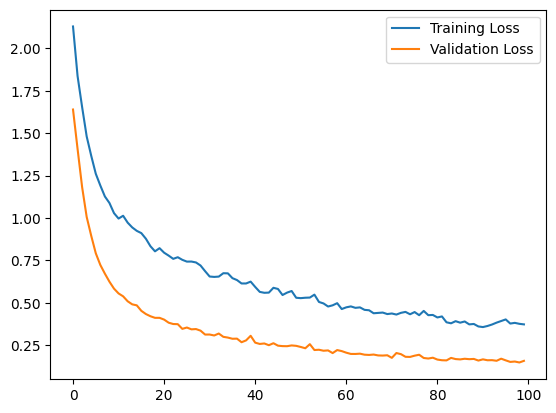

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
p = model.predict(X_test, batch_size=batch_size)
final_layer = pd.DataFrame(p)
final_layer

3/3 [==============================] - 0s 68ms/step


,0,1,2,3,4,5,6,7,8,9
0,0.001294,6.006395e-08,0.992990,9.006394e-05,0.000975,0.000329,0.000448,0.001257,0.002021,0.000597
1,0.000002,4.168650e-04,0.001313,6.304747e-04,0.000919,0.000012,0.000181,0.962603,0.028146,0.005776
2,0.000003,4.664846e-04,0.001465,6.812452e-04,0.001051,0.000015,0.000164,0.963100,0.024922,0.008132
3,0.000012,1.904187e-04,0.003529,2.018641e-04,0.002292,0.000043,0.015306,0.045955,0.932422,0.000048
4,0.000002,4.071176e-04,0.001314,6.251057e-04,0.000907,0.000012,0.000196,0.960841,0.030530,0.005166
...,...,...,...,...,...,...,...,...,...,...
2735,0.001187,6.449345e-04,0.000981,6.443947e-04,0.000840,0.000635,0.000002,0.006119,0.000048,0.988899
2736,0.000165,6.761812e-05,0.000750,6.649496e-08,0.993868,0.000558,0.000493,0.001510,0.001889,0.000700
2737,0.000009,4.027846e-04,0.003858,4.058939e-04,0.002967,0.000049,0.008558,0.163207,0.820329,0.000215
2738,0.000002,4.163886e-04,0.001392,6.325329e-04,0.000968,0.000013,0.000179,0.962564,0.027600,0.006233


In [ ]:
del model

In [ ]:
final_layer.to_pickle(f"{path}/final_layer.pkl")

### UMAP

In [ ]:
umap_2d = UMAP(n_components=2, n_neighbors=67, init='random', metric= "chebyshev", random_state=0, min_dist=1)
proj_2d = umap_2d.fit_transform(final_layer)

In [ ]:
plot_df = pd.DataFrame(proj_2d, columns = ["D1", "D2"])
plot_df["color"] = y_test.tolist()
plot_df.head()

In [ ]:
plt.figure(figsize=(6,6))

sns.scatterplot(x="D1", y="D2", s=50, hue="color", data=plot_df, legend=True)
plt.xlabel("UMAP 1", fontsize=16)
plt.ylabel("UMAP 2", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(f"{path}/merged_UMAP_DseepCC.pdf", format="pdf")
plt.legend(prop={'size': 10}, loc="lower right", ncol=2)
plt.tight_layout()
plt.show()

### Clustering metrics

In [ ]:
silhouetteScore = silhouette_score(final_layer, y_test, metric="euclidean")
davies_bouldinScore = davies_bouldin_score(final_layer, y_test)

km = KMeans(n_clusters=10, random_state=42)
y_pred = km.fit_predict(final_layer)
ari = adjusted_rand_score(y_pred, y_test)

print(f"Silhuette score: {round(silhouetteScore,3)}", f"Rand Index {round(ari, 3)}", f"Davies-Bouldin score {round(davies_bouldinScore,3)}")

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhuette score: 0.5189999938011169 Rand Index 0.645 Davies-Bouldin score 0.844
